# Deep Neural Network for Image Classification: Application

- Build and train a deep L-layer neural network, and apply it to supervised learning

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- [4 - Two-layer Neural Network](#4)
- [5 - L-layer Neural Network](#5)
- [6 - Results Analysis](#6)
- [7 - Test with images](#7)

<a name='1'></a>
## 1 - Packages

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

from deeplearning.modelling import DeepNNModel

%matplotlib inline
plt.rcParams["figure.figsize"] = (5.0, 4.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288  # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

<a name='2'></a>
## 2 - Load and Process the Dataset

**Problem Statement**:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

In [3]:
def load_data():
    train_dataset = h5py.File("../datasets/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(
        train_dataset["train_set_x"][:]
    )  # your train set features
    train_set_y_orig = np.array(
        train_dataset["train_set_y"][:]
    )  # your train set labels

    test_dataset = h5py.File("../datasets/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations (per hundreds)")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams["figure.figsize"] = (40.0, 40.0)  # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]

        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(64, 64, 3), interpolation="nearest")
        plt.axis("off")
        plt.title(
            "Prediction: "
            + classes[int(p[0, index])].decode("utf-8")
            + " \n Class: "
            + classes[y[0, index]].decode("utf-8")
        )

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


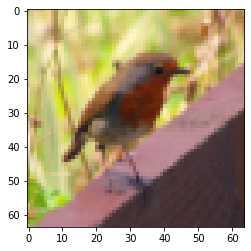

In [5]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print(
    "y = "
    + str(train_y[0, index])
    + ". It's a "
    + classes[train_y[0, index]].decode("utf-8")
    + " picture."
)

In [6]:
# Explore your dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [7]:
# Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(
    train_x_orig.shape[0], -1
).T  # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Build a deep neural network to distinguish cat images from non-cat images!

Build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, compare the performance of these models, and try out some different values for $L$. 

- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

<a name='4'></a>
## 4 - Two-layer Neural Network

In [8]:
model = DeepNNModel()
parameters, costs = model.train(
    train_x, train_y, layers_dims=(n_x, n_h, n_y), num_iterations=2, print_cost=False
)
print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 1: 0.6564026188409187
Cost after first iteration: 0.6950464961800915


Cost after iteration 0: 0.6950464961800915
Cost after iteration 100: 0.5892596054583806
Cost after iteration 200: 0.5232609173622991
Cost after iteration 300: 0.4497686396221906
Cost after iteration 400: 0.4209002161883899
Cost after iteration 500: 0.3724640306174595
Cost after iteration 600: 0.34742051870201895
Cost after iteration 700: 0.3171919198737027
Cost after iteration 800: 0.26643774347746596
Cost after iteration 900: 0.21991432807842567
Cost after iteration 1000: 0.14357898893623774
Cost after iteration 1100: 0.4530921262322131
Cost after iteration 1200: 0.09499357670093511
Cost after iteration 1300: 0.08014128076781368
Cost after iteration 1400: 0.06940234005536462
Cost after iteration 1500: 0.06021664023174592
Cost after iteration 1600: 0.053274157580018765
Cost after iteration 1700: 0.04762903262098433
Cost after iteration 1800: 0.04297588879436867
Cost after iteration 1900: 0.03903607436513821
Cost after iteration 2000: 0.035683136380490275
Cost after iteration 2100: 0.03

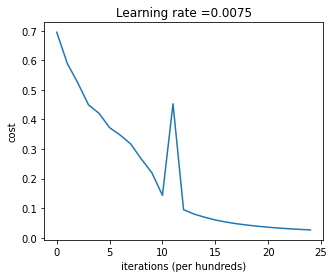

In [9]:
parameters, costs = model.train(
    train_x, train_y, layers_dims=(n_x, n_h, n_y), num_iterations=2500, print_cost=True
)
plot_costs(costs, learning_rate)

In [10]:
parameters

{'W1': array([[ 0.01089224,  0.0284369 ,  0.01078057, ...,  0.0080023 ,
          0.0213506 , -0.01679771],
        [ 0.00886607,  0.00177879, -0.00619542, ...,  0.00597638,
         -0.00471923,  0.00169947],
        [-0.009572  , -0.01509918, -0.00664024, ...,  0.0053515 ,
         -0.00763015,  0.00176105],
        ...,
        [-0.00292846,  0.01161239, -0.01206897, ...,  0.00412827,
          0.01063505, -0.00853653],
        [ 0.03201614,  0.01668004,  0.01324017, ..., -0.00262379,
          0.00384041,  0.01112038],
        [ 0.00476812,  0.03269814, -0.00376539, ...,  0.01936407,
         -0.00410175, -0.00666902]]),
 'b1': array([[ 0.04757795],
        [-0.00071134],
        [-0.00705294],
        [-0.00024674],
        [ 0.00238968],
        [ 0.01091515],
        [ 0.01645444]]),
 'W2': array([[-1.48934825,  0.99264695,  0.62301954,  1.06424421, -0.09135046,
          1.12600548, -0.46244854]]),
 'b2': array([[-0.07481785]])}

In [11]:
predictions_train = model.predict(train_x, train_y)

Accuracy: 0.9999999999999998


In [12]:
predictions_test = model.predict(test_x, test_y)

Accuracy: 0.74


<a name='5'></a>
## 5 - L-layer Neural Network

In [16]:
### CONSTANTS ###
layers_dims = [12288, 64, 32, 16, 1]  #  4-layer model

In [165]:
model = DeepNNModel()
parameters, costs = model.train(
    train_x,
    train_y,
    layers_dims,
    num_iterations=1,
    print_cost=False,
    lambd=6,
    keep_prob=0.5,
    parameters=parameters,
)

print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 0: 2.1948118244602366
Cost after first iteration: 2.1948118244602366


In [181]:
model = DeepNNModel()
parameters, costs = model.train(
    train_x,
    train_y,
    layers_dims,
    num_iterations=1400,
    print_cost=True,
    lambd=4,
    keep_prob=0.94,
    parameters=parameters,
)

Cost after iteration 0: 0.021988814380766077
Cost after iteration 100: 0.015525202965062827
Cost after iteration 200: 0.014169850459247253
Cost after iteration 300: 0.013349024215065494
Cost after iteration 400: 0.012810411738535558
Cost after iteration 500: 0.012439434282743137
Cost after iteration 600: 0.012184925473262775
Cost after iteration 700: 0.01201236953492587
Cost after iteration 800: 0.011881440385473108
Cost after iteration 900: 0.01178867319770816
Cost after iteration 1000: 0.01172485250840723
Cost after iteration 1100: 0.011675163213538719
Cost after iteration 1200: 0.011624826809062051
Cost after iteration 1300: 0.01158851434622746
Cost after iteration 1399: 0.011551273275313583


In [182]:
pred_train = model.predict(train_x, train_y, parameters)

Accuracy: 0.9760765550239232


In [183]:
pred_test = model.predict(test_x, test_y, parameters)

Accuracy: 0.76


<a name='6'></a>
##  6 - Results Analysis

First, take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

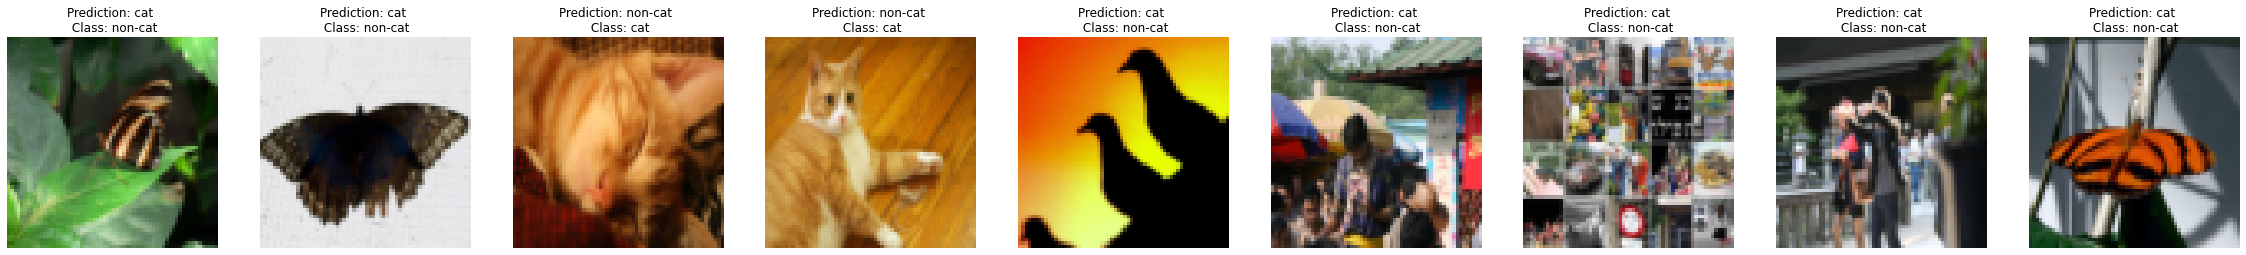

In [97]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

<a name='7'></a>
## 7 - Test with images

In [184]:
def test_image(my_image, parameters):

    fname = "../images/" + my_image
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    plt.imshow(image)
    image = image / 255.0
    image = image.reshape((1, num_px * num_px * 3)).T

    model = DeepNNModel()
    my_predicted_image = model.predict(image, parameters=parameters)

    print(
        "y = "
        + str(np.squeeze(my_predicted_image))
        + ', your L-layer model predicts a "'
        + classes[
            int(np.squeeze(my_predicted_image)),
        ].decode("utf-8")
        + '" picture.'
    )

y = 0.0, your L-layer model predicts a "non-cat" picture.


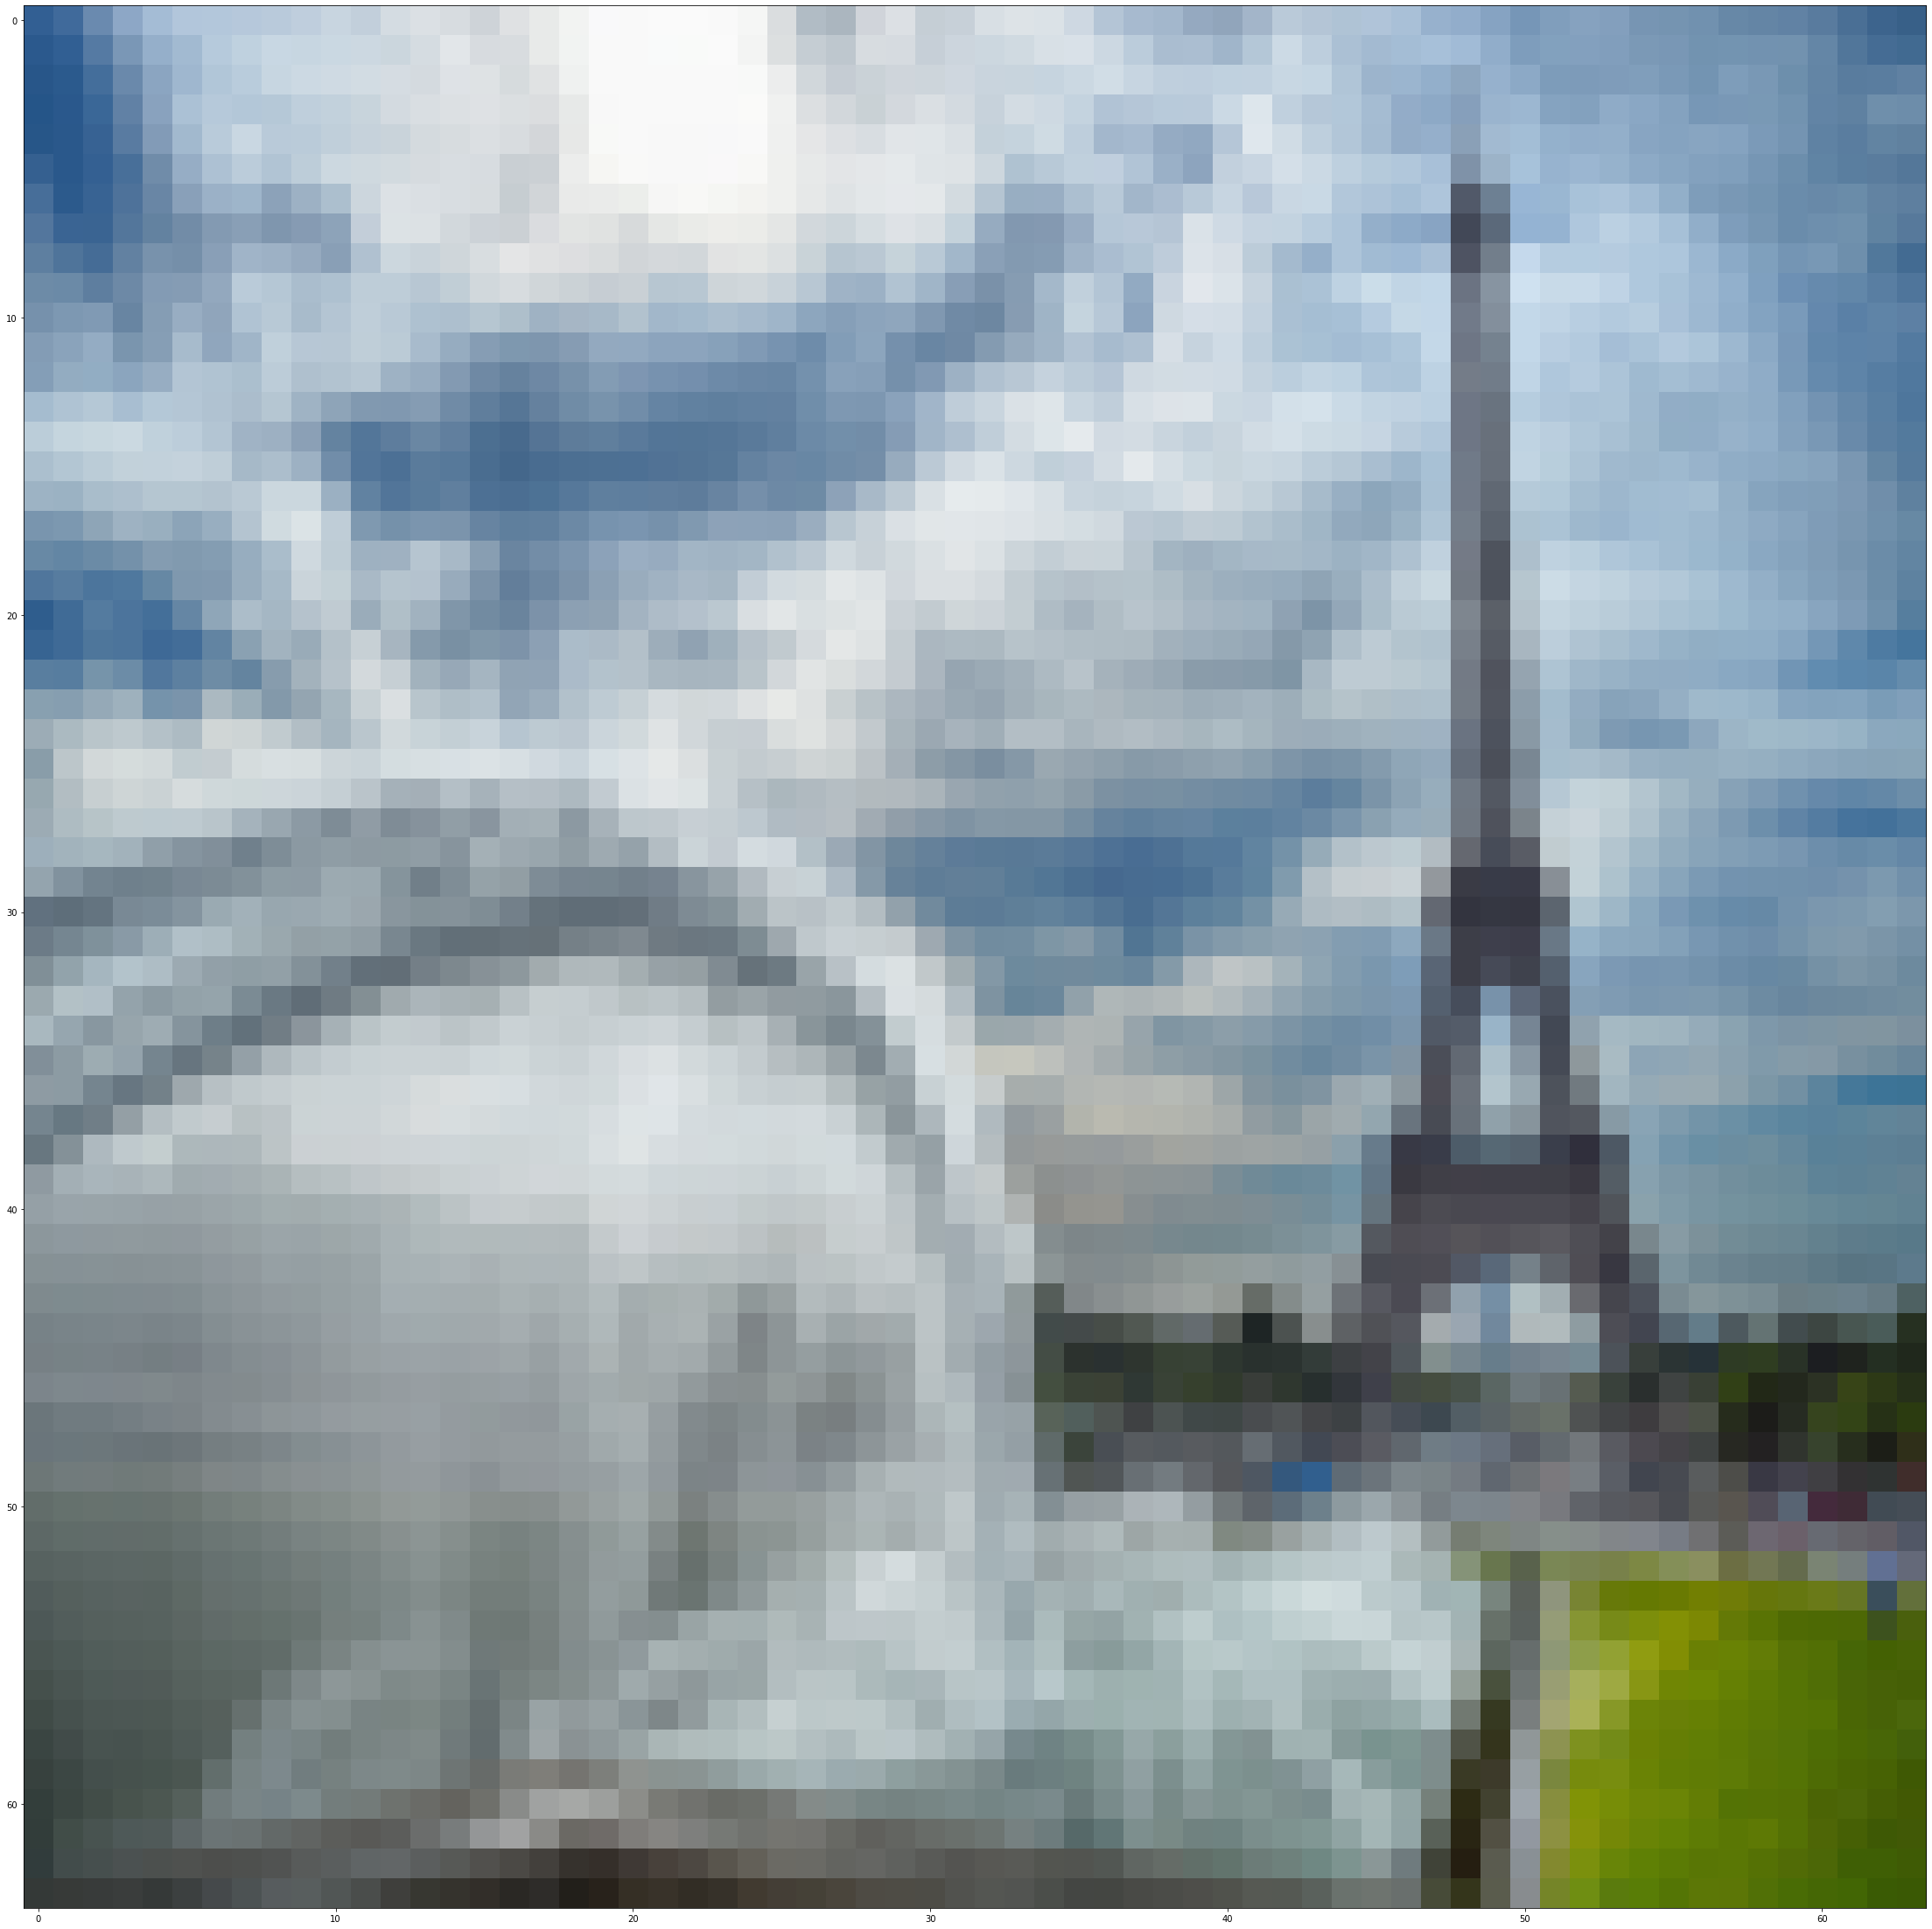

In [185]:
test_image("my_image.jpg", parameters)

y = 1.0, your L-layer model predicts a "cat" picture.


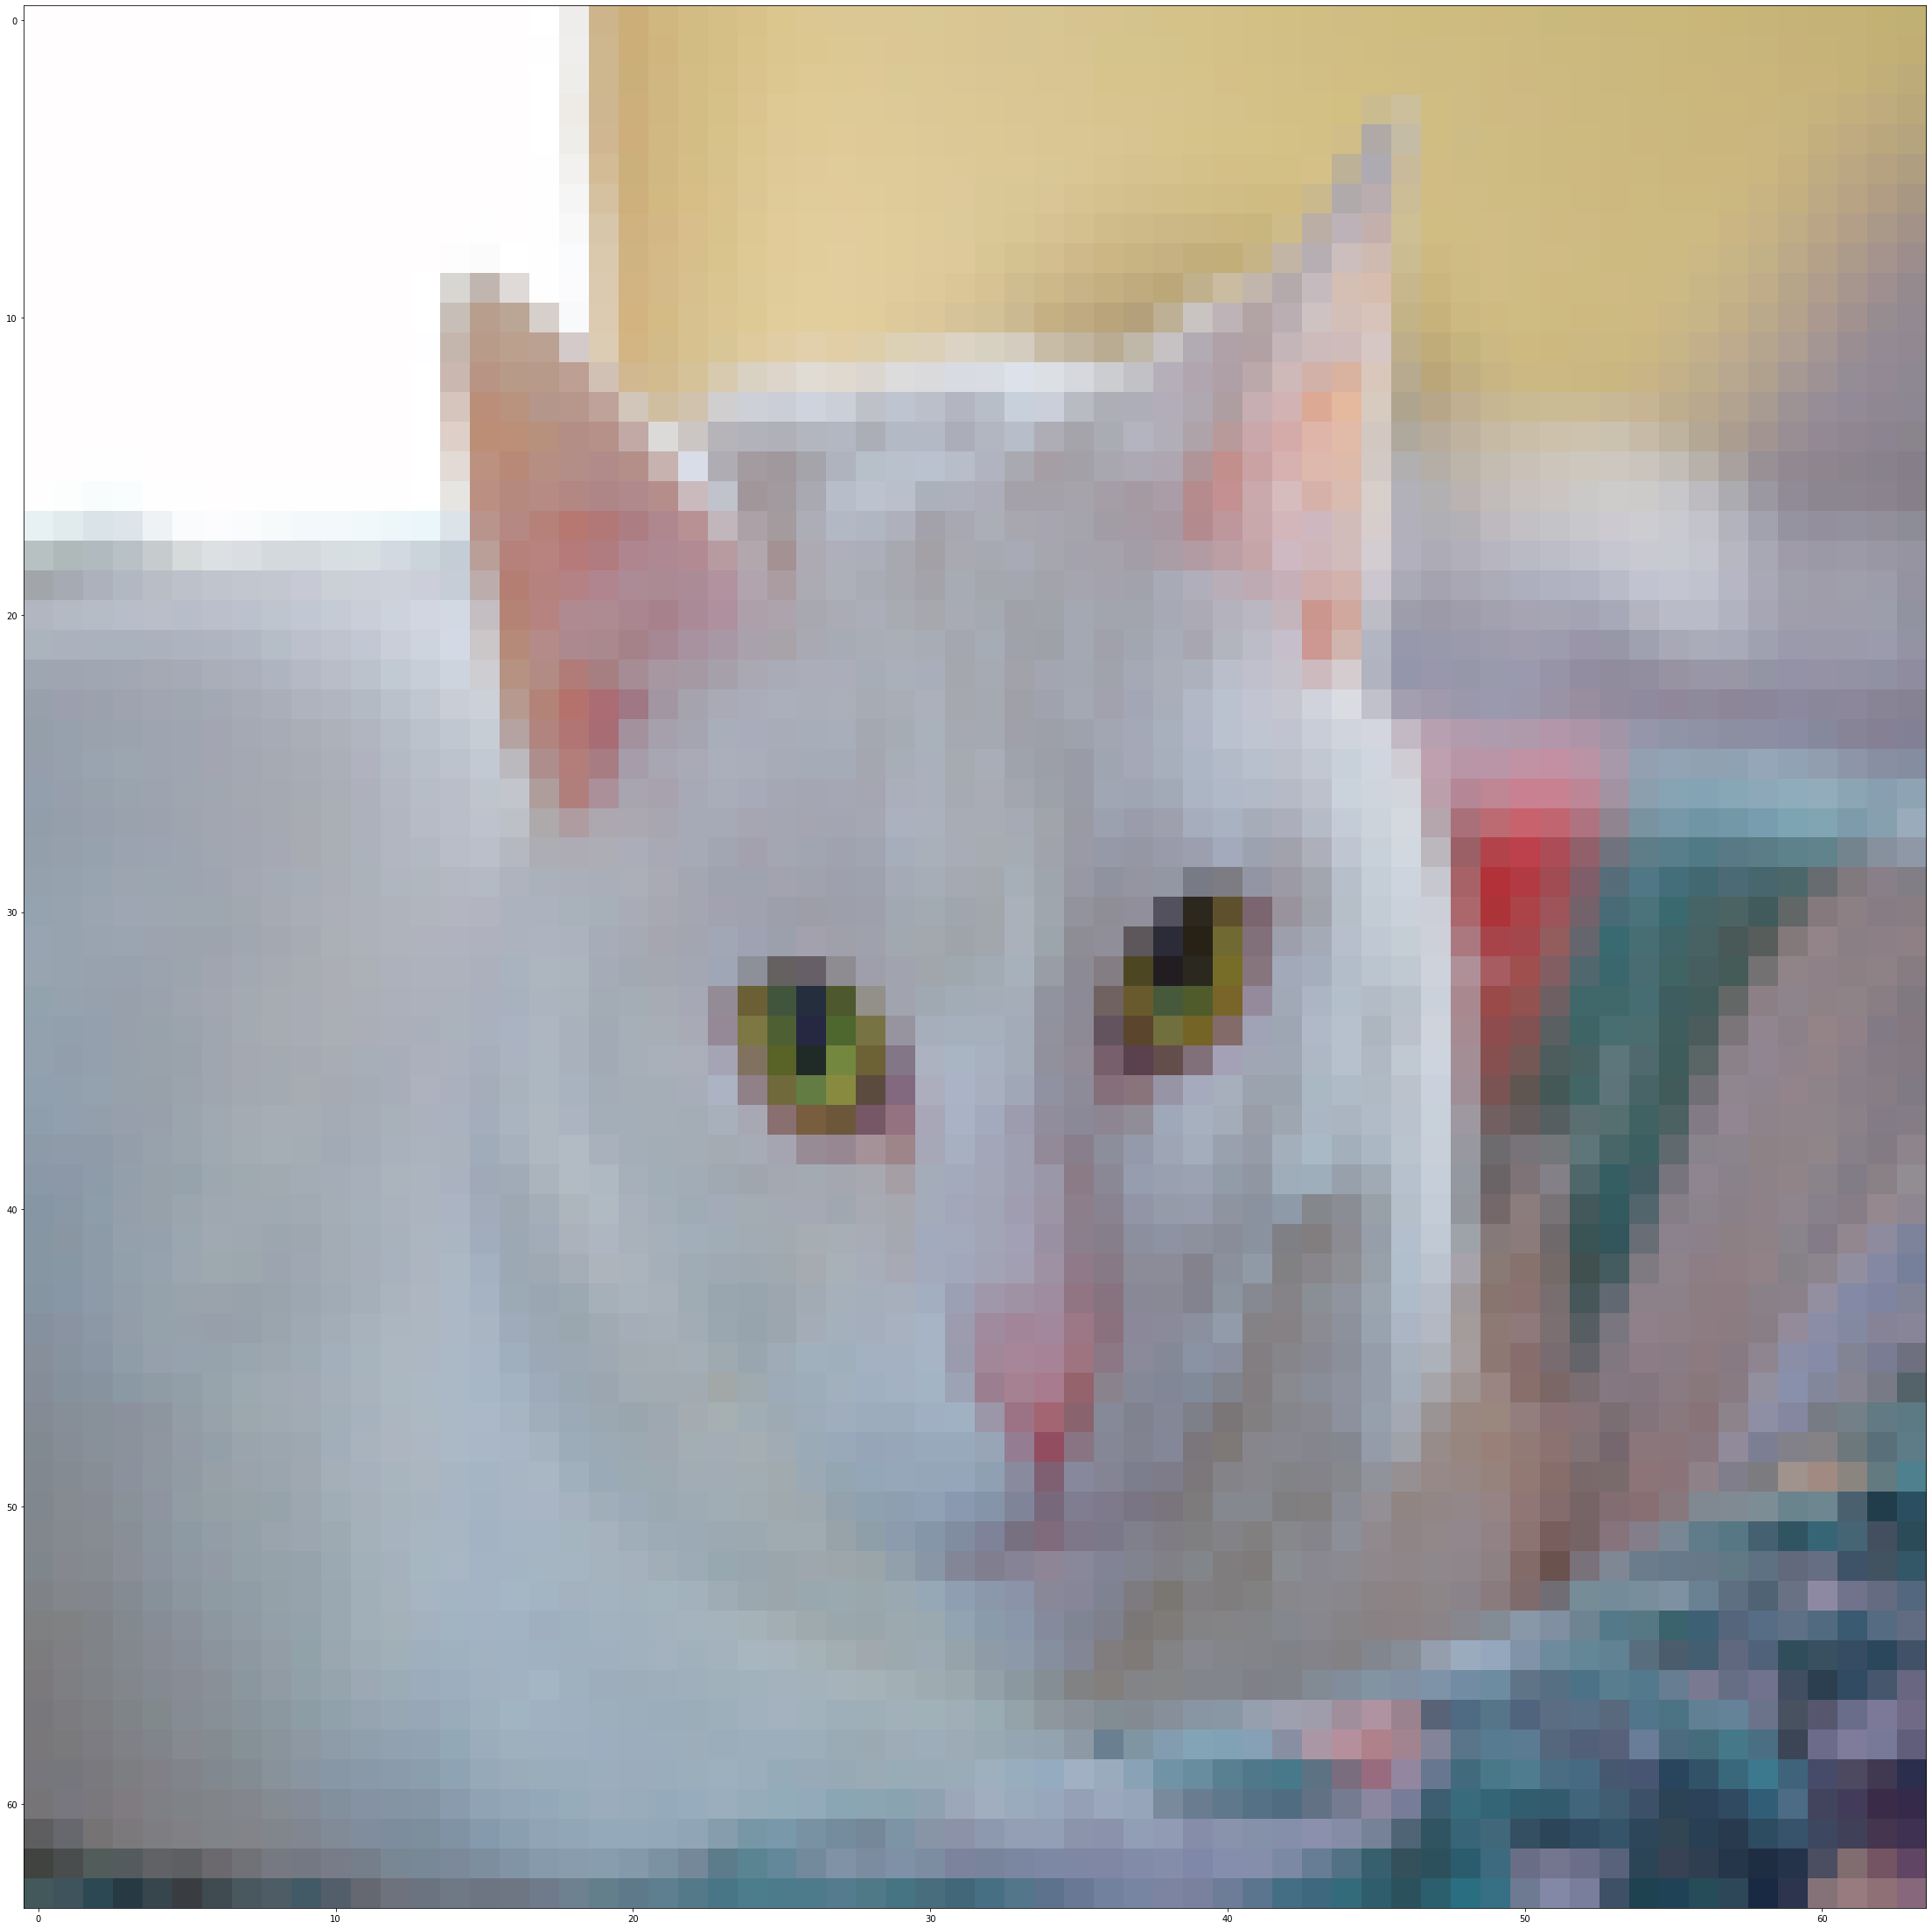

In [186]:
test_image("my_image2.jpg", parameters)

y = 0.0, your L-layer model predicts a "non-cat" picture.


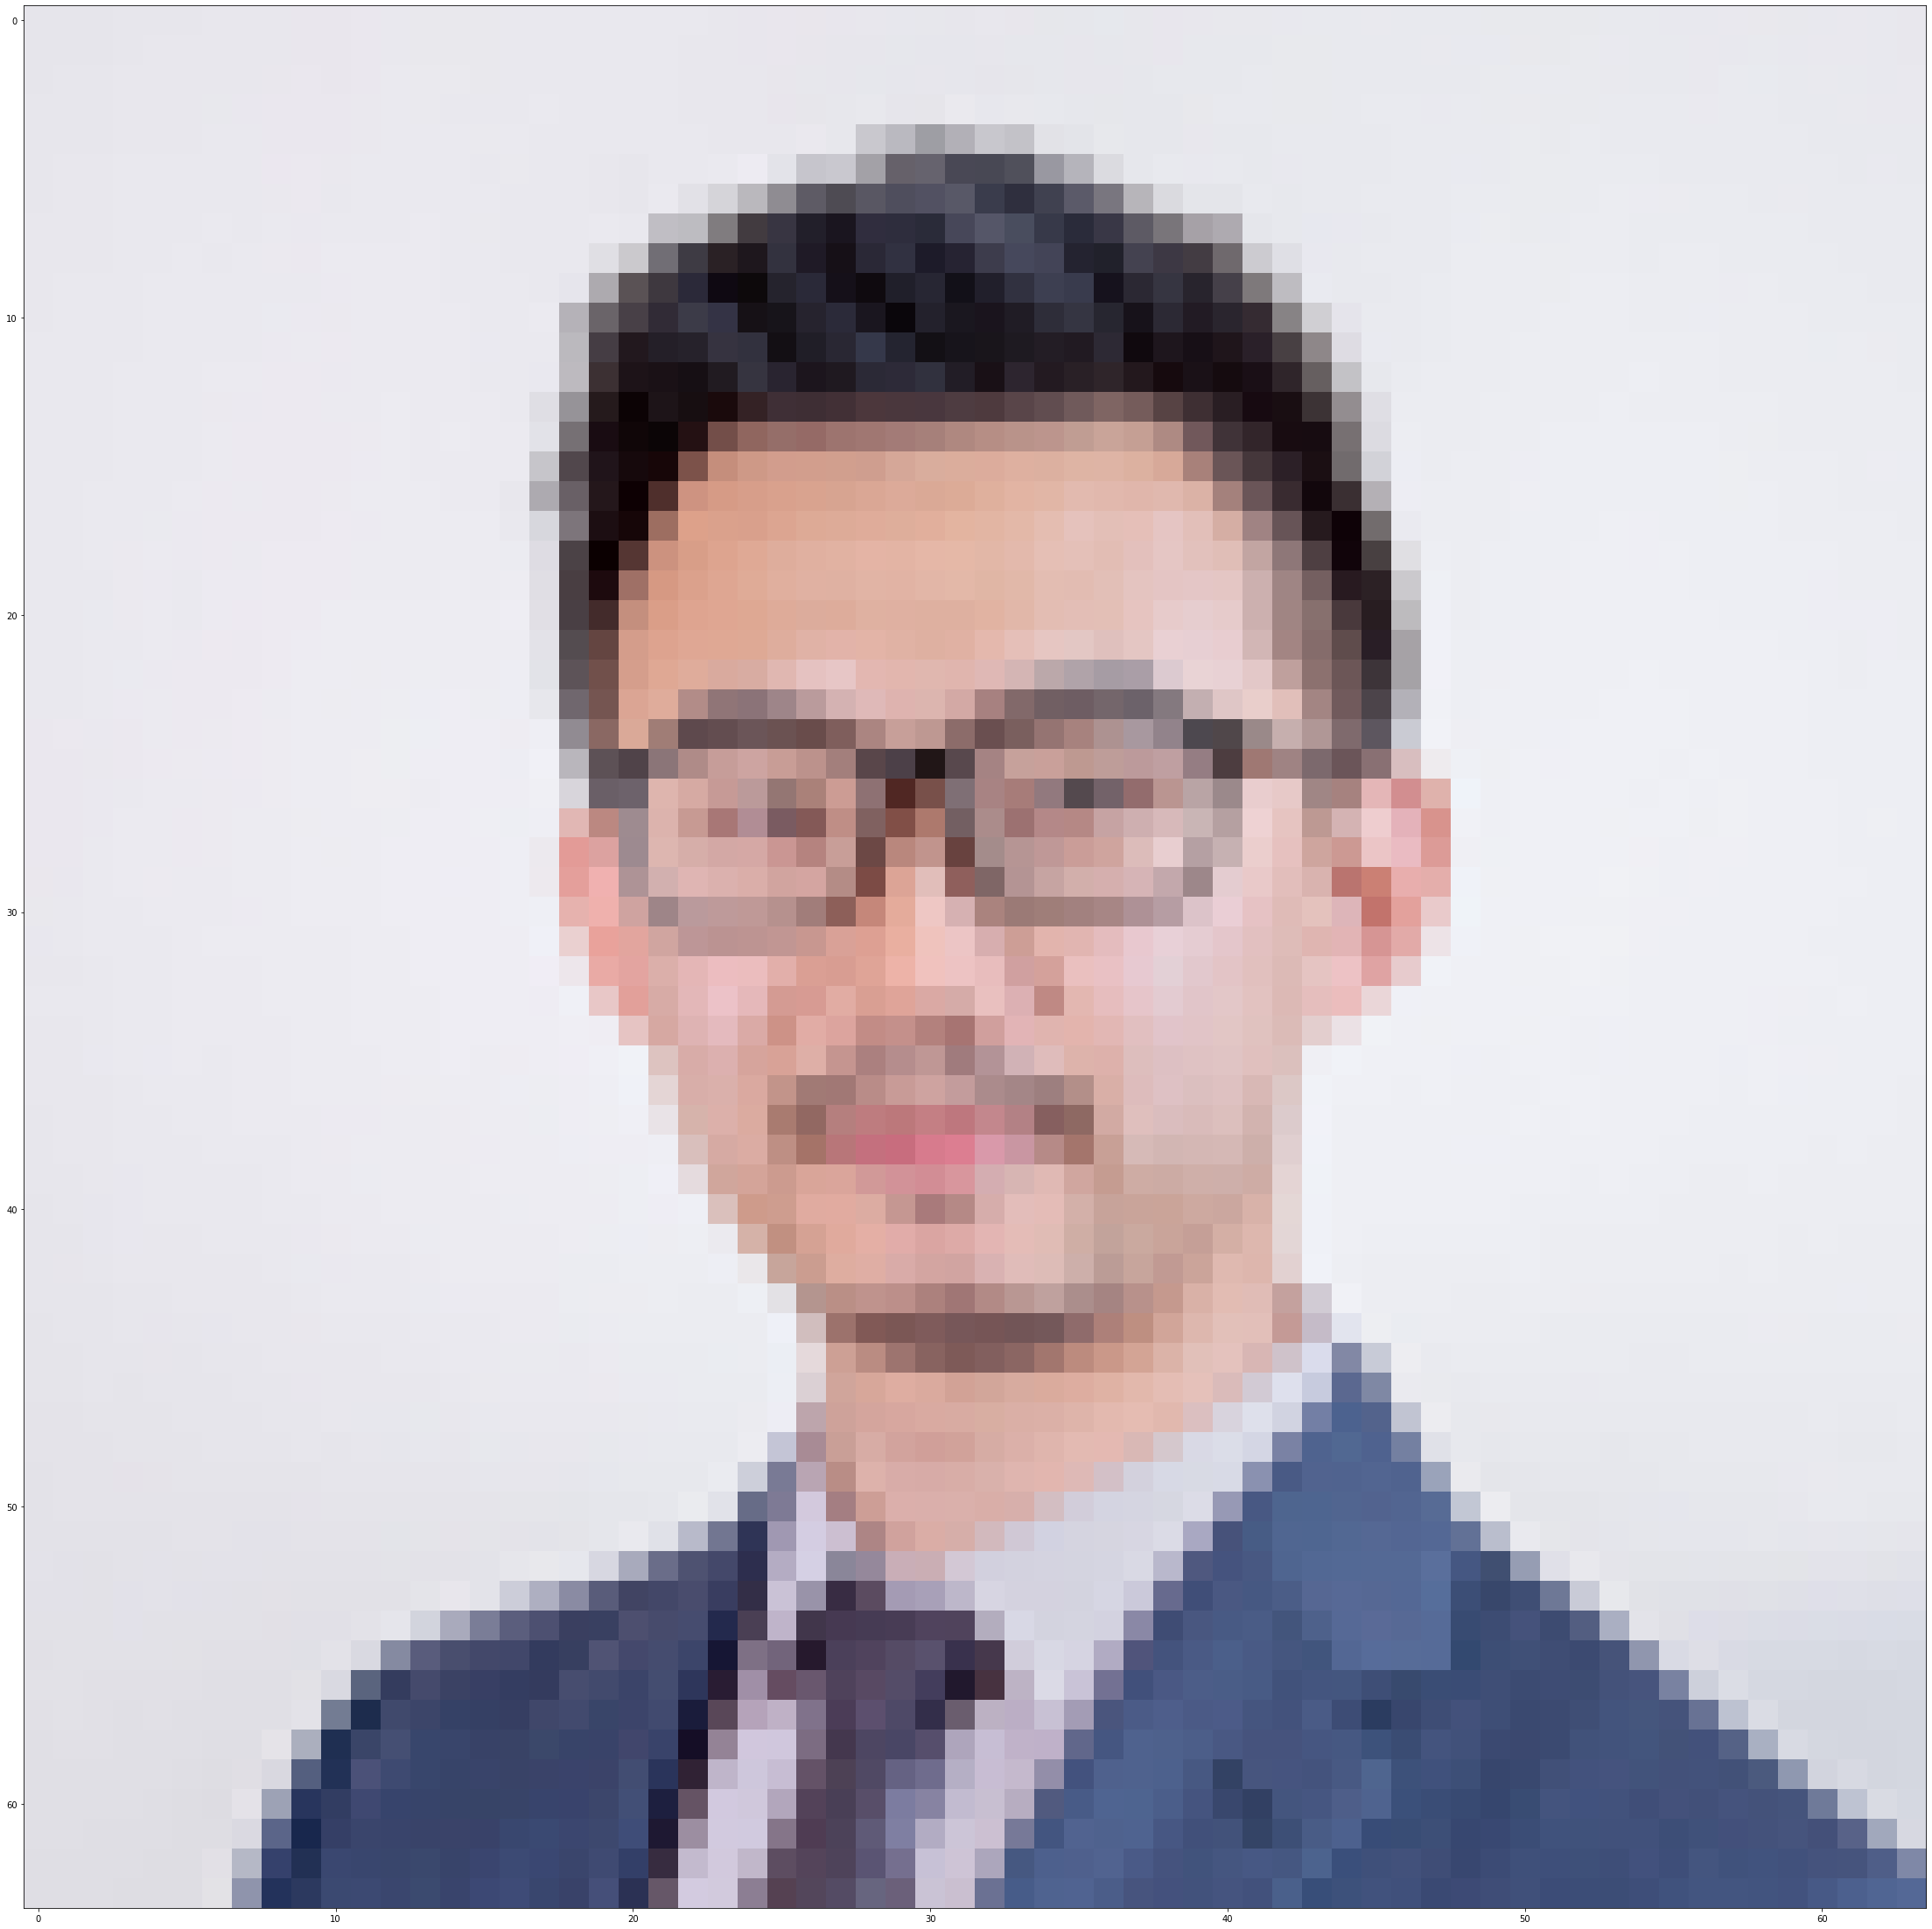

In [187]:
test_image("1561040958920.jpg", parameters)